# Generating input with varying frequency

Create a small striatal network, with population units, and then simulate the neurons while they receive time varying input.

In [1]:
import os
network_path = os.path.join("networks","frequency_test")
rc = None

In [2]:
bg_data_path = os.path.join("..", "..", "..", "..", "BasalGangliaData", "data")
if os.path.isdir(bg_data_path):
    os.environ["SNUDDA_DATA"] = bg_data_path
    print(f"export SNUDDA_DATA={bg_data_path}")

export SNUDDA_DATA=../../../../BasalGangliaData/data


## Define the network

Here we define a small network with dSPN, iSPN and FS neurons. We also define two population units (with dSPN and iSPN) within the network (1 and 2), the remaining neurons do not have a population unit (i.e. set to zero). See the ```n_neurons```, ```n_pop_unit_1``` and ```n_pop_unit_2``` variables below.

In [ ]:
import numpy as np
from snudda import SnuddaInit

config_file = os.path.join(network_path, "network-config.json")
si = SnuddaInit(config_file=config_file, random_seed=12345)

# Number of neurons in simulation, and size of population unit 1 and 2
n_neurons = 40
n_pop_unit_1 = 15
n_pop_unit_2 = 15

f_dSPN = 0.475
f_iSPN = 0.475
f_FS = 0.013
f_TOT = f_dSPN + f_iSPN + f_FS
n_dSPN = n_neurons * f_dSPN / f_TOT
n_iSPN = n_neurons * f_iSPN / f_TOT
n_FS = n_neurons * f_FS / f_TOT

si.define_striatum(num_dSPN=n_dSPN, num_iSPN=n_iSPN, num_FS=n_FS, num_LTS=0, num_ChIN=0,
                   volume_type="cube", neurons_dir="$DATA/neurons")

# The centre of the cube is [0.00475, 0.004, 0.00775]. num_neurons is optional
si.add_population_unit_density(structure_name="Striatum", neuron_types=["dSPN", "iSPN"], 
                               unit_centre=np.array([0.00475, 0.004, 0.00775]) -np.array([0,50e-6,150e-6]),
                               probability_function="(d < 200e-6)*1", num_neurons=n_pop_unit_1)
si.add_population_unit_density(structure_name="Striatum", neuron_types=["dSPN", "iSPN"], 
                               unit_centre=np.array([0.00475, 0.004, 0.00775]) -np.array([150e-6,0,0]),
                               probability_function="(d < 200e-6) * 1", num_neurons=n_pop_unit_2)
 
si.write_json(config_file)

## Place the neurons, and plot the network

In [ ]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path)
sp.place()

In [ ]:
from snudda.plotting import PlotNetwork
pos_file = os.path.join(network_path, "network-neuron-positions.hdf5")

pn = PlotNetwork(pos_file)
pn.plot_populations()

# The commented code below also plots the network, but with the option to plot more detail of the neurons:
# pn = PlotNetwork(network_path)
# pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False, colour_population_unit=True)

pn.close()  # Close the hdf5 file so others can use it (or better shut down kernel after)

# Starting an ```ipcluster``` for parallel execution

In the same folder as the notebook is located run the commands below to start the ipcluster. Make sure to wait a little between when you start the ipcluster and when you then continue running the cells below, so that the cluster have time to startup and the workers are registered and receiving work.

```
export IPYTHONDIR="`pwd`/.ipython"
export IPYTHON_PROFILE=default
export SNUDDA_DATA=../../../../BasalGangliaData/data
ipcluster start
```

If you did not have the ```BasalGangliaData``` installed, then do not do the last export with ```SNUDDA_DATA```.

To later stop the cluster, press ```Ctrl + C``` or run:

```
ipcluter stop
```

## Define ```rc``` to make Snudda aware of the ipyparallel remote client

In [ ]:
import os
from ipyparallel import Client

os.environ["IPYTHONDIR"] = ".ipython"
os.environ["IPYTHON_PROFILE"] = "default"

u_file = os.path.join(".ipython", "profile_default", "security", "ipcontroller-client.json")
if os.path.exists(u_file):
    rc = Client(url_file=u_file, timeout=120, debug=False)
else:
    print("Warning, running in serial.")
    rc = None

## Touch detection and pruning of the network synapses

If Snudda complains about mismatching keys, then make sure that your parallel engines also have the ```SNUDDA_DATA``` set correctly.

In [ ]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, rc=rc)
sd.detect()

In [ ]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path, rc=rc)
sp.prune()

## Defining the input to the neuron population

Here we want to define a time varying input for the neurons. Population unit 1 receies 10Hz and population unit 2 receives 60Hz. First population unit 1 is activated, then population unit 2, then both population units simulatenous.

For the ```frequency_function``` input we set the ```populationUnitCorrelation``` to 0, since they will be correlated by virtue of the frequency oscillation.

In [ ]:
from snudda.input import SnuddaInput
si = SnuddaInput(network_path=network_path, 
                 input_config_file="input-config.json",
                 time=3.0, rc=rc,
                 verbose=False)
si.generate()

## Plot the input spikes

The inputs are defined in ```input-config.json```. Below is shown a portion of the file, and the different fields are explained.

```
{
    "dSPN": {
        "Ctx_1" : {
	    "populationUnitID" : 1,	    
            "generator" : "frequency_function",
            "start" : [0.5, 2.5],
            "end" : [1, 3],
            "frequency" : "70*(1+sin(2*3.14159*10*t))",
            "conductance" : 0.5e-9,
            "nInputs" : 20,
            "populationUnitCorrelation" : 0,
            "jitter" : 0,        
            "modFile": "tmGlut"
        },

...continued.
```

First ```dSPN``` specifies which neurons should receive this input, it can be either a neuron type, neuron sub-type like ```dSPN_1``` or a ```neuron_id``` like ```'13'``` (JSON wants strings for keys). 

The input is named, here we choose ```Ctx_1```. The ```generator``` ```frequency_function``` means that we specify the frequency as a function of t (as a string). We specify ```start``` and ```end``` here the input is on 0.5 -- 1 second, and 2.5 -- 3 seconds. 

The ```frequency``` is ```"70*(1+sin(2*3.14159*10*t))"``` which means it will oscillate at 10 Hz, with an amplitude of 70. We also specify the ```conductance```, number of inputs ```nInputs```. Because the input is already correlated due to variation in firing frequency we set ```populationUnitCorrelation``` to 0 and ```jitter``` to 0. The ```modFile``` is ```tmGlut``` since we have glutamatergic synapses.


In [ ]:
from snudda.plotting import PlotInput
input_file = os.path.join(network_path, "input-spikes.hdf5")
spi = PlotInput(input_file)

In [ ]:
spi.plot_input_population_unit(population_unit_id=1, num_neurons=5, fig_size=(15,5))

In [ ]:
spi.plot_input_population_unit(population_unit_id=2, num_neurons=5, fig_size=(15,5))

## Compile the NEURON mechanisms

In [ ]:
!nrnivmodl $SNUDDA_DATA/neurons/mechanisms

In [ ]:
!mpiexec -n 3 snudda simulate networks/frequency_test --time 3

Loading 38 neurons with 1100 synapses and 0 gap junctions
Loading networks/frequency_test/simulation/output.hdf5
Saving figure to networks/frequency_test/figures/spike_raster.pdf


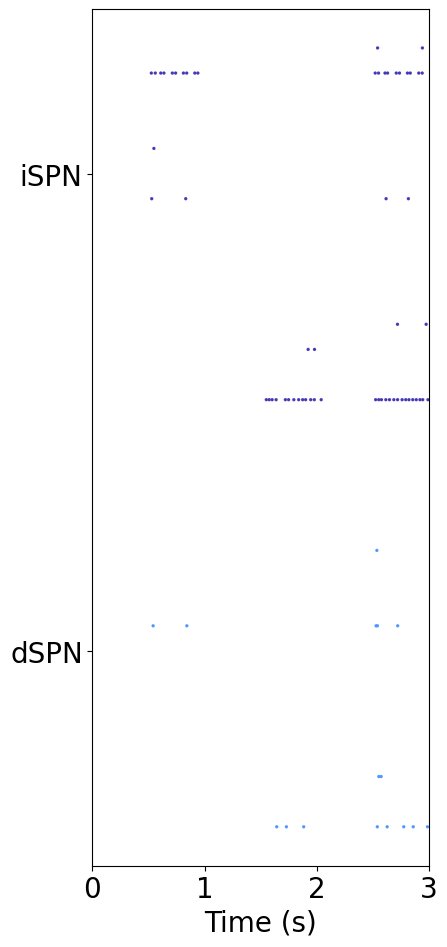

In [3]:
from snudda.plotting import SnuddaPlotSpikeRaster2

type_order = ["chin", "dspn", "lts", "ispn", "fs", "fsn"]

sp = SnuddaPlotSpikeRaster2(network_path=network_path)

sp.plot_spike_raster(type_order=type_order, fig_size=(5,10))